In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import glob
from scipy.optimize import least_squares

# Camera Calibration and Undistorting Images
In this notebook we are going to calibrate a monocular camera (i.e. estimate the camera matrix and distortion parameters) and use the calibration to undistort an image. We will start by using the standard OpenCV functions first and later implement the calibration and undistortion form scratch using numpy and scipy.
## Camera Calibration using OpenCV
I have printed out a [chessboard pattern](https://github.com/opencv/opencv/blob/master/doc/pattern.png) and took pictures of it with a wide angle industrial-grade camera. We will follow the [official OpenCV tutorial on camera calibration](https://docs.opencv.org/master/dc/dbb/tutorial_py_calibration.html).

In [2]:
# Extract circle centers for all images. This might take a while...
image_files = glob.glob('data/*.png')

grid_size = 25 # mm
grid_shape = (9,6)

image_corners = np.zeros((0, grid_shape[0]*grid_shape[1] ,2))
chessboard_positions = np.zeros((grid_shape[0]*grid_shape[1],3))
chessboard_positions[:,:2] = np.mgrid[0:grid_shape[0],0:grid_shape[1]].T.reshape(-1,2)
chessboard_positions *= grid_size
image_shape = np.array([])

for file in image_files:
    img = cv2.cvtColor(cv2.imread(file), cv2.COLOR_BGR2GRAY)
    image_shape = img.shape
    ret, corners = cv2.findChessboardCorners(img, grid_shape)
    if ret:
        image_corners = np.append(image_corners, np.array(corners).reshape(1, -1, 2), axis=0)
    else:
        print(f"No chessboard detected in image {file}")
print(f"Processed {len(image_files)} images and found {image_corners.shape[0]} chessboards.")

Processed 28 images and found 28 chessboards.


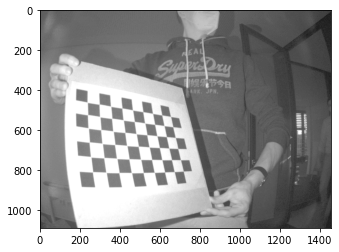

In [3]:
example_image_id = 22 # choose example image for the rest of the task
img = cv2.cvtColor(cv2.imread(image_files[example_image_id]), cv2.COLOR_BGR2GRAY) 
plt.imshow(img, cmap='gray');

In [4]:
def calibrate_camera_openCV():
    object_points = np.tile(chessboard_positions, (image_corners.shape[0], 1, 1))
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(object_points.astype(np.float32), image_corners.astype(np.float32), image_shape[::-1], None, None)
    
    n = len(rvecs)
    transformations = np.zeros((n, 3, 4))
    for i in range(n):
        transformations[i,:,:3] = cv2.Rodrigues(rvecs[i])[0]
        transformations[i,:,3] = tvecs[i].flatten()
    
    
    return mtx, dist[0], transformations

camera_mat_cv, dist_cv, transformations_cv = calibrate_camera_openCV()
print("Camera matrix returned by OpenCV:")
with np.printoptions(suppress=True, precision=2):
    print(camera_mat_cv)
print("Distortion coefficients returned by OpenCV:")
print(f"k1: {dist_cv[0]:+.3e}; \tk2: {dist_cv[1]:+.3e}; \tp1: {dist_cv[2]:+.3e}; \tp2: {dist_cv[3]:+.3e}, ; \tk3: {dist_cv[4]:+.3e}")

Camera matrix returned by OpenCV:
[[1142.98    0.    710.28]
 [   0.   1155.9   542.24]
 [   0.      0.      1.  ]]
Distortion coefficients returned by OpenCV:
k1: -4.832e-01; 	k2: +2.913e-01; 	p1: -2.613e-04; 	p2: -7.658e-04, ; 	k3: -1.103e-01


After having estimated the camera matrix and the distortion, we can undistort the image. The benefit of working with an undistorted image is that we can completely forget the distortion coefficients. Thus, we are in the ideal case of a pinhole camera which allows us to work directly with the camera matrix.

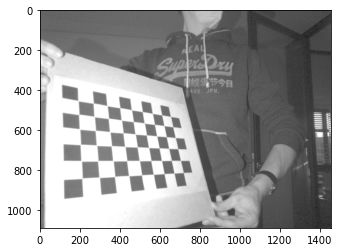

In [5]:
undistorted_img_cv = cv2.undistort(img, camera_mat_cv, dist_cv)
plt.imshow(undistorted_img_cv, cmap='gray');

## Camera Calibration from Scratch
### Estimating the Camera Matrix
In this section we are going to implement the camera calibration procedure inspired by [Zhang '98](https://www.microsoft.com/en-us/research/wp-content/uploads/2016/02/tr98-71.pdf). 
We write down the perspective projection equation for a planar grid. The origin of the world is therefore defined by the chessboardd pattern. Note that all z-coordinates are zero because all world points lie on the plane. 

$$ 
    \lambda \left( \begin{array}{r} u \\ v \\ 1 \end{array}\right) = K 
    \left[ \begin{array}{c c} R_{cw} &  T_{cw} \end{array}\right] 
    \left( \begin{array}{c} X_w \\ Y_w \\ 0 \\ 1\end{array}\right) = 
    \underbrace{K \left[ \begin{array}{c c } r_1 & r_2 & t\end{array}\right]}_{H} 
    \left( \begin{array}{c} X_w \\ Y_w \\ 1\end{array}\right)
$$

The matrix $H$ is the same for all corners in one image and can be estimated using for example the **direct linear transform (DLT)**. This however assumes that all elements in $H$ are independent which in in general not the case. We will only use the DLT only as a first guess and refine the estimation later on using all constraints.

$$ 
    \lambda \left( \begin{array}{r} u \\ v \\ 1 \end{array}\right) = 
    \left( \begin{array}{ccc}
        h_{11} & h_{12} & h_{13}\\ h_{21} & h_{22} & h_{23} \\ h_{31} & h_{32} & h_{33}
    \end{array}\right) 
    \left( \begin{array}{c} X_w \\ Y_w \\ 1\end{array}\right) = 
    \left( \begin{array}{c}h_1^T \\ h_2^T \\ h_3^T\end{array}\right) P 
    \Rightarrow 
    \left\{
    \begin{array}{l l}
        u = \frac{\lambda u}{\lambda} = \frac{h_1^T \cdot P}{h_3^T \cdot P} \\ 
        v = \frac{\lambda v}{\lambda} = \frac{h_2^T \cdot P}{h_3^T \cdot P}
    \end{array}\right.
    \Rightarrow 
    \left\{
    \begin{array}{l l}
        (h_1^T - u h_3^T)\cdot P=0 \\ 
        (h_2^T - v h_3^T)\cdot P=0 
    \end{array}\right.
    \Rightarrow 
    \left( \begin{array}{ccc}
    P^T & 0^T & -uP^T \\0^T & P^T & -vP^T
    \end{array}\right) 
    \left( \begin{array}{c}h_1 \\ h_2 \\ h_3\end{array}\right) =0 
$$

This reasoning can be applied to all n corners in one image and the resulting equations can be stacked to yield one big matrix. The matrix $Q$ can be constructed using the observed corners. The least square solution for $H$ can be found with the **Singular Value Decomposition (SVD)** ([Wikipedia](https://en.wikipedia.org/wiki/Singular_value_decomposition#Solving_homogeneous_linear_equations)).
$$ 
    \underbrace{
        \left( \begin{array}{ccc}
            P_1^T & 0^T & -u_1P_1^T \\
            0^T & P_1^T & -v_1P_1^T \\ 
            P_2^T & 0^T & -u_2P_2^T \\
            0^T & P_2^T & -v_2P_2^T \\
            \vdots & \vdots & \vdots \\
            P_n^T & 0^T & -u_nP_n^T \\
            0^T & P_n^T & -v_nP_n^T 
        \end{array} \right)}_{Q\in\mathbb{R}^{2n \times 9}
    }
    \left( \begin{array}{c}
        h_1 \\ h_2 \\ h_3\end{array}\right) = Q \cdot H' = 0
$$

In [6]:
def calculate_H_DLT(corners, chessboard_positions):
    n = corners.shape[0]
    
    P = chessboard_positions.copy();
    P[:,2] = 1
    
    Q = np.zeros((2*n, 9))
    Q[::2,0:3] = P
    Q[1::2,3:6] = P
    Q[::2,6:9] = -(P.T * corners[:,0]).T
    Q[1::2,6:9] = -(P.T * corners[:,1]).T
    
    U, D, Vh = np.linalg.svd(Q, full_matrices=True)
    # Row in vh that is associated with the smalles singular value gives solution
    H_tilde = Vh[-1,:]
    H = H_tilde.reshape(3,3)
    return H
    
def test_H_DLT():
    H_0 = calculate_H_DLT(image_corners[0], chessboard_positions)
    print(H_0)  
    
    # Check that perspective projection equation is approximately fulfilled
    P = chessboard_positions.copy();
    P[:,2] = 1
    
    pixels_h = H_0 @ P.T;
    pixels = pixels_h[0:2,:]/pixels_h[2,:]
    
    print("Average perspective projection equation error:", 
          np.average(np.linalg.norm(pixels.T - image_corners[0], axis=1)), 'px')

test_H_DLT()

Hs = np.array([calculate_H_DLT(image_corners[i], chessboard_positions) for i in range(image_corners.shape[0])])

[[ 3.29630154e-03 -9.91348816e-05  9.94815674e-01]
 [ 3.60585913e-04  2.48710966e-03  1.01604198e-01]
 [ 8.69468292e-07 -2.31490884e-07  1.08200461e-03]]
Average perspective projection equation error: 3.1432817240835074 px


We can now compute the homography $H_i$ for each image $i$. Note that the scale of $H$ can be arbitrary chosen beause the homogeneous equation $Q\cdot sH'=0$ is satisfied for any $s\in\mathbb{R}$. In the next step we need to extract the camera matrix from all matrices $H_i$. We will use the constraints imposed by the rotation matrix and rewrite the vectors $r_1$ and $r_2$ using $H$ and $K$ (and an unknown scale factor $s$). The vectors $g_j$ are the column vectors of $H$ and are not to be confused with the row vectors $h_j$ used in the derivation of $H$.
$$ 
    H = \left[ \begin{array}{c c c} g_1 & g_2 & g_3 \end{array}\right] = 
    sK\left[ \begin{array}{c c c} r_1 & r_2 & t \end{array}\right] \Rightarrow \left\{
    \begin{array}{l l} r_1 = s^{-1} K^{-1}g_1 \\ r_2 = s^{-1} K^{-1}g_2 \end{array}\right.
$$
The constraints on the rotation matrix impose that $r_1$ and $r_2$ are orthonormal which translates to:
$$ 
    \begin{align}
        r_1 \cdot r_2 = 0 & \Rightarrow g_1^TK^{-T}K^{-1}g_2 = 0 \\
        r_1 \cdot r_1 = 1 = r_2 \cdot r_2 & \Rightarrow g_1^TK^{-T}K^{-1}g_1 = g_2^TK^{-T}K^{-1}g_2.
    \end{align}
$$

We define the symmetric matrix $B$ which is defined by the vector $b'= \left( \begin{array}{llllll} b_{11} & b_{12} & b_{22} & b_{13}  & b_{23} & b_{33} \end{array}\right)^T$ as
$$ 
    B = \left( \begin{array}{ccc}
        b_{11} & b_{12} & b_{13}\\ b_{12} & b_{22} & b_{23} \\ b_{13} & b_{23} & b_{33}
    \end{array}\right)  = K^{-T}K^{-1}.
$$
Using this noteation, the constraints can be rewritten as linear function of $b'$:
$$ 
    g_i^T B g_j = v_{ij}^Tb' 
$$
with 
$$ 
    v_{ij} = \left( \begin{array}{llllll} 
        h_{1,i}h_{1,j} & h_{1,i}h_{2,j}+h_{2,i}h_{1,j} & h_{2,i}h_{2,j} &
        h_{3,i}h_{1,j}+h_{1,i}h_{3,j} & h_{3,i}h_{2,j}+h_{2,i}h_{3,j} & h_{3,i}h_{3,j}
    \end{array}\right)^T.
$$
The corresponding two homogeneous equation in $b'$ are:
$$ 
    \left( \begin{array}{c}
    v_{12}^T \\ (v_{11}-v_{22})^T
    \end{array}\right) b' = 0. 
$$
For each image $i$ we obtain two homogeneous equations that we stack to the matrix $V$. $b'$ is found again with the SVD.
$$ 
    Vb'=0
$$

In [7]:
def calculate_B_DLT(Hs):
    def v(i, j, H):
        # Note the 0 indexing in numpy
        return np.array([H[0,i]*H[0,j], 
                         H[0,i]*H[1,j] + H[1,i]*H[0,j], 
                         H[1,i]*H[1,j], 
                         H[2,i]*H[0,j] + H[0,i]*H[2,j], 
                         H[2,i]*H[1,j] + H[1,i]*H[2,j],
                         H[2,i]*H[2,j]])
    
    n = image_corners.shape[0]
    V = np.zeros((2*n, 6))
    
    for i in range(n):
        H = Hs[i,:,:]
        V[2*i,:] = v(0, 1, H)
        V[2*i+1,:] = v(0, 0, H) - v(1, 1, H)
        
    U, D, Vh = np.linalg.svd(V, full_matrices=True)
    b = Vh[-1,:]
    B = np.array([[b[0], b[1], b[3]],
                  [b[1], b[2], b[4]],
                  [b[3], b[4], b[5]]])
    return B

B = calculate_B_DLT(Hs)
print(B)

[[-4.68150525e-07  6.00240130e-09  2.40863315e-04]
 [ 6.00240130e-09 -4.95816300e-07  2.34648791e-04]
 [ 2.40863315e-04  2.34648791e-04 -9.99999943e-01]]


In [8]:
np.linalg.eig(B)

(array([-1.00000006e+00, -3.61077723e-07, -4.89813863e-07]),
 array([[ 2.40863399e-04, -7.86720208e-01,  6.17309692e-01],
        [ 2.34648879e-04, -6.17309648e-01, -7.86720244e-01],
        [-9.99999943e-01, -3.34343140e-04, -3.59157147e-05]]))

We can finally recover the calibration matrix $K$ from $B$ using the **Cholesky Factorization**. Keep in mind that we can only estimate $B$ up to a constant scale factor $\alpha$. Therefore $B=\alpha K^{-T}K^{-1}.$ We can safely ignore the scale factor at first and later rescale the obtained matrix $K$ so that $K_{33} =1$. Recall that the Cholesky Factorization factorizes a square matrix $A$ in the product of a lower-triangular matrix $L$ and a upper-triangular matrix $L^T$: $A=LL^T$. We apply this to $B$:
$$ B = LL^T = K'^{-T}K'^{-1} \Rightarrow K'=L^{-T} $$
The camera matrix $K$ can now be recovered as:
$$ K = \frac{1}{K'_{33}}K' $$

In [9]:
def B_to_K(B):
    # B can have arbitrary sign and Cholesky needs positive definite matrix. 
    try:
        L = np.linalg.cholesky(B)
    except np.linalg.LinAlgError:
        L = np.linalg.cholesky(-B) 
    K_p = np.linalg.inv(L).T
    K = K_p/K_p[2,2] # Recovers scale by forcing K_33 to be 1
    
    # Due to numeric imprecisions elements below the diaglonal are note exactely 0. We set then to 0 to be consistent.
    K[1,0] = K[2,0] = K[2,1] = 0
    return K

camera_mat = B_to_K(B)
with np.printoptions(suppress=True, precision=2):
    print("Our initial guess for the camera matrix")
    print(camera_mat)
    print("Camera matrix obtained by OpenCV")
    print(camera_mat_cv)

Our initial guess for the camera matrix
[[1275.86   15.9   520.65]
 [   0.   1239.85  479.56]
 [   0.      0.      1.  ]]
Camera matrix obtained by OpenCV
[[1142.98    0.    710.28]
 [   0.   1155.9   542.24]
 [   0.      0.      1.  ]]


As we can see we are already pretty close to the OpenCV solution which is a good sign! :) 
We can now also estimate the transformation from world to camera for each image by reusing the homographies and formulas seen above:
$$ 
    \begin{align}
        r_1 &= s^{-1} K^{-1}g_1 \\ 
        r_2 &= s^{-1} K^{-1}g_2 \\
        r_3 &= r_1 \times r_2\\
        t &= s^{-1} K^{-1}g_3
    \end{align}
$$
where $s$ is a normalization constant.

In [10]:
def calculate_transformations(Hs, K):
    n = Hs.shape[0]
    transformations = np.zeros((n, 3, 4))
    for i in range(n):
        H = Hs[i]
        r1p = np.linalg.solve(K, H[:,0])
        s = np.linalg.norm(r1p)
        transformations[i,:,0] = r1p/s
        transformations[i,:,1] = np.linalg.solve(K, H[:,1])/s
        transformations[i,:,2] = np.cross(transformations[i,:,0], transformations[i,:,1])
        transformations[i,:,3] = np.linalg.solve(K, H[:,2])/s
    return transformations
transformations = calculate_transformations(Hs, camera_mat)
print("Calculated transformation for first image:")
print(transformations[0])
print("OpenCV transformation for first image:")
print(transformations_cv[0])

Calculated transformation for first image:
[[ 9.31483064e-01 -3.90410603e-03 -3.16244274e-01  1.43053434e+02]
 [-1.89988804e-02  8.75563471e-01  8.86778781e-02 -1.40623538e+02]
 [ 3.63288238e-01 -9.67233838e-02  8.15498371e-01  4.52091871e+02]]
OpenCV transformation for first image:
[[ 9.93453223e-01  3.85081744e-02  1.07553776e-01  8.80934023e+01]
 [-1.70199685e-02  9.80859168e-01 -1.93973230e-01 -1.85314028e+02]
 [-1.12964663e-01  1.90872768e-01  9.75093109e-01  4.43579286e+02]]


### Distortion Coefficients
One could try to estimate the distortion coefficients by using a least squares approach as described in Zhang's paper to obtain an initial guess. This guess can then be refined with non-linear optimization. In practice however one can often skip this step and initialize the refinement with all distortion coefficients set to 0.
We first need to define a function that maps from undistorted pixel coordinates to distorted coordinates (see notebook *Image Formation* for more detailed information):

In [11]:
def distort(uv, K, distortion_coeffs):
    alpha_u = K[0,0]; alpha_v = K[1,1]
    u0 = K[0,2]; v0 = K[1,2]
    k1 = distortion_coeffs[0]; k2 = distortion_coeffs[1]; k3 = distortion_coeffs[4]
    p1 = distortion_coeffs[2]; p2 = distortion_coeffs[3];
    
    # Convert to nomalized coordinates
    xy = (uv - np.array([u0, v0]))/np.array([alpha_u, alpha_v])
    
    r2 = np.sum(xy**2, axis = 1)
    
    xyd = (xy.T * (1 + k1*r2 + k2*r2**2 + k3*r2**3)).T    
    
    xyd[:,0] += 2*p1*xy[:,0]*xy[:,1] + p2*(r2 + 2*xy[:,0]**2)
    xyd[:,1] += p1*(r2 + 2*xy[:,1]**2) + 2*p2*xy[:,0]*xy[:,1]

    uvd = xyd * np.array([alpha_u, alpha_v]) + np.array([u0, v0])    
    return uvd
dist = np.zeros(dist_cv.shape) # We have not yet estimated the distortion, we set the initial value to 0

#### Reprojection Error
The reprojection error measures the euclidian distance in pixels between the observed corner position and the position obtained by projecting the point using $K$ and the distortion coefficients. 

In [12]:
def reproject(world_coords, transformation, K, distortion_coeffs=np.zeros(5)):
    world_coords_h = np.ones((world_coords.shape[0], 4))
    world_coords_h[:,:3] = world_coords
    uv_h = (K @ transformation @ world_coords_h.T).T
    uv = (uv_h[:,:2].T/uv_h[:,2]).T
    uvd = distort(uv, K, distortion_coeffs)
    return uvd
    
def reprojection_error(observed_pixel_coords, world_coords, transformation, K, distortion_coeffs):
    error = np.linalg.norm(reproject(world_coords, transformation, K, distortion_coeffs) 
                           - observed_pixel_coords, axis=1)
    return error

def average_reprojection_error(image_corners, chessboard_positions, transformations, K, distortion_coeffs):
    return np.average([np.average(reprojection_error(image_corners[i], chessboard_positions, 
                                                     transformations[i], K, distortion_coeffs))
                       for i in range(image_corners.shape[0])])

print("Average reprojection error for OpenCV camera matrix and distortion:")
print(average_reprojection_error(image_corners, chessboard_positions, transformations_cv, camera_mat_cv, dist_cv))
print("Average reprojection error for our camera matrix without distortion:")
print(average_reprojection_error(image_corners, chessboard_positions, transformations, camera_mat, dist))

Average reprojection error for OpenCV camera matrix and distortion:
0.8896733531697921
Average reprojection error for our camera matrix without distortion:
2.0877179855570622


We can see that the OpenCV solution has a lower reprojection error, which is normal because we have not yet estimated the distortion coefficients. 

### Non-Linear Optimization
We will now minimize the sum of squared reprojection errors of all collected corners using non-linear optimization. This will allow to simultaneously estimate the distortion coefficient and refine the camera matrix and transformations. 
We have also the possiblity to force certain parameters to specific values. We force $K_{1,2}$ to be zero so that it matches the pinhole camera model that we derived. Having $K_{1,2}\neq0$ corresponds to having non-rectangular pixels which is not the case any more in modern cameras.

We need to be careful when dealing with rotations: there are different representations for a rotation as for example the rotation matrix or a rotation vector. A rotation matrix is easy to manipulate but has 9 parameters and internal constraints (orthonormal vectors). A rotation vector is less convenient to use but only has 3 independent parameters which is suitable for optimization! We will use OpenCV's [Rodrigues function](https://docs.opencv.org/3.4/d9/d0c/group__calib3d.html#ga61585db663d9da06b68e70cfbf6a1eac) for converting between the representations.

We assemble a large parameter vector which contains the camera intrinsics, the distortion coefficients and the rotation + translation parameters for each view.

In [13]:
def to_param_vec(K, dist_coeffs, transformations):
    n_views = transformations.shape[0]
    param_vec = np.array([K[0,0], # alpha_u
                          K[1,1], # alpha_v
                          K[0,2], # u_0
                          K[1,2]])# v_0
    param_vec = np.append(param_vec, dist_coeffs)
    for i in range(n_views):
        t = transformations[i,:,3]
        r = cv2.Rodrigues(transformations[i,:,:3])[0].flatten()
        param_vec = np.append(param_vec, [t,r])

    return param_vec, n_views

def from_param_vec(param_vec, n_views):
    K = np.array([[param_vec[0], 0,            param_vec[2]],
                  [0,            param_vec[1], param_vec[3]],
                  [0,            0,            1]])
    dist_coeffs = param_vec[4:9]
    transformations = np.zeros((n_views, 3, 4))
    for i in range(n_views):
        start_idx = 9+6*i
        t = param_vec[start_idx:start_idx+3]
        r = param_vec[start_idx+3:start_idx+6]
        transformations[i,:,3] = t
        transformations[i,:,:3] = cv2.Rodrigues(r)[0]
    return K, dist_coeffs, transformations

param_vector, n_views = to_param_vec(camera_mat, dist, transformations)

The function that we minimize is the sum (over images and corners in this image) of squared reprojection errors and can be written as:

$$ 
    \DeclareMathOperator*{\argmin}{arg\,min}
    K, D, T_{i=1:n} = \argmin_{K, D, T_{i=1:n}} \sum_{i=1}^{n} \sum_{c=1}^{m} \Vert p_{c_i} - \pi(P_c, K, D, T_i) \Vert_{2}^{2}
$$
where $p_{c_i}$ is the observed pixel position of corner $c$ in image $i$, and $\pi(P_c, K, D, T_i)$ is the projection of the corner $P_c$ to image $i$.

We will use [scipy's non-linear least-squares solver](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.least_squares.html) which expects an error vector as input. It will minimize the norm of this error vector which is equivalent to the minimization described above. The solver can be given additional information like the jacobian (obtained e.g. by automatic differentiation). In the scope of this notebook however, we will let the solver handle everything including the numeric differentiation for estimating the jacobian. And it just works! :)

In [14]:
def error_fun(param_vec, image_corners):
    K, dist_coeffs, transformations = from_param_vec(param_vec, n_views)
    err_vec = np.zeros(n_views * 2 * image_corners.shape[1])
    for i in range(n_views):
        err_vec[i*2*image_corners.shape[1]:(i+1)*2*image_corners.shape[1]] = \
            (image_corners[i] - reproject(chessboard_positions, transformations[i], K, dist_coeffs)).flatten()
    return err_vec
opt_result = least_squares(error_fun, param_vector, args=[image_corners])

In [15]:
camera_mat_opt, dist_opt, transformations_opt = from_param_vec(opt_result.x, n_views)

with np.printoptions(suppress=True, precision=5):
    def print_method_results(name, transformations, K, dist):
        print("*** "+ name +" ***")
        print("Average reprojection error:")
        print(average_reprojection_error(image_corners, chessboard_positions, transformations, K, dist))
        print("Norm of error vector:")
        print(np.linalg.norm(error_fun(to_param_vec(K, dist, transformations)[0], image_corners)))
        print("Camera Matrix:")
        print(K)
        print("Distortion parameters:")
        print(dist)
        print("\n")
    print_method_results("Pinhole model without distortion", transformations, camera_mat, dist)
    print_method_results("OpenCV", transformations_cv, camera_mat_cv, dist_cv)
    print_method_results("Pinhole model with distortion", transformations_opt, camera_mat_opt, dist_opt)

*** Pinhole model without distortion ***
Average reprojection error:
2.0877179855570622
Norm of error vector:
1200.8742995174514
Camera Matrix:
[[1275.86196   15.89678  520.64842]
 [   0.      1239.85174  479.56054]
 [   0.         0.         1.     ]]
Distortion parameters:
[0. 0. 0. 0. 0.]


*** OpenCV ***
Average reprojection error:
0.8896733531697921
Norm of error vector:
42.04742475270586
Camera Matrix:
[[1142.97697    0.       710.28052]
 [   0.      1155.89543  542.24438]
 [   0.         0.         1.     ]]
Distortion parameters:
[-0.48318  0.29133 -0.00026 -0.00077 -0.11033]


*** Pinhole model with distortion ***
Average reprojection error:
0.8896731789830046
Norm of error vector:
42.04742475449538
Camera Matrix:
[[1142.97701    0.       710.28167]
 [   0.      1155.89544  542.24615]
 [   0.         0.         1.     ]]
Distortion parameters:
[-0.48318  0.29133 -0.00026 -0.00077 -0.11033]




We have successfully recreated the calibration obtained by OpenCV in a few lines of Python code!

## Undistorting Images
After having obtained the distortion parameters, we can now undistort the image as explained in the notebook *Image Formation*. The great advantage of undistorted images is that one can completely forget about the distortion coefficients and only work with the pinhole camera model! 

The procedure of undistorting an image requires interpolating between pixels. There are [different kinds of interpolation](https://docs.opencv.org/3.4/da/d54/group__imgproc__transform.html#ga5bb5a1fea74ea38e1a5445ca803ff121) with different properties. In this notebook we will implement **bilinear interpolation** which is relatively easy to implement and yields much better results than nearest neighbour interpolation.

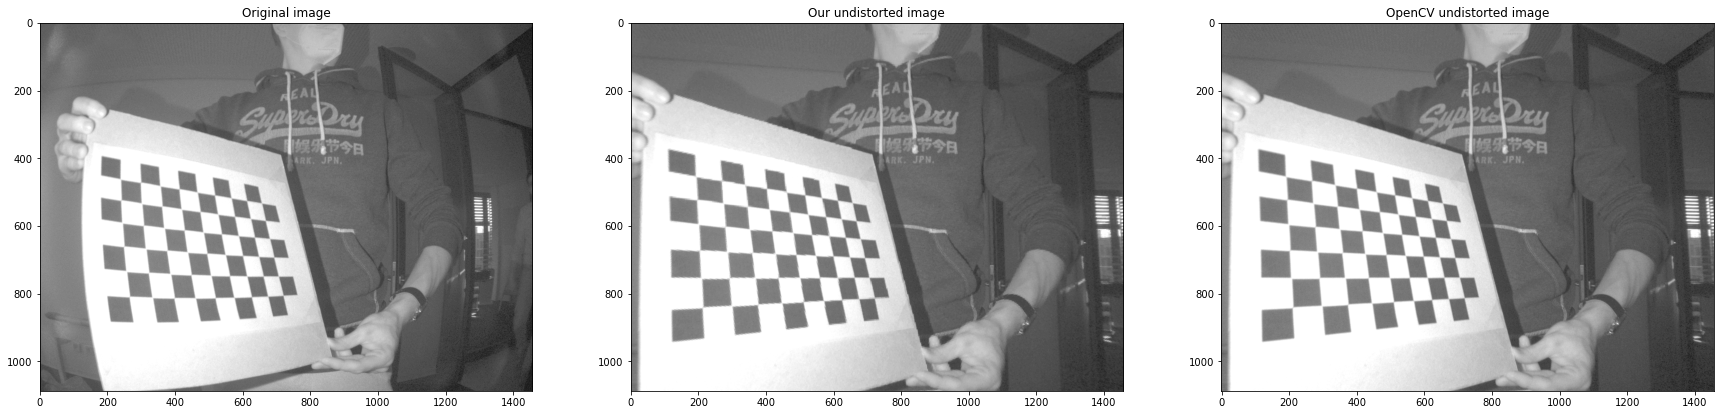

In [16]:
def bilinear_interpolation(image, coords_x, coords_y):
    assert(coords_x.shape == coords_y.shape == image.shape)
    out_of_image_mask = np.logical_or(
        np.logical_or(coords_x >= image.shape[1], coords_x < 0),
        np.logical_or(coords_y >= image.shape[0], coords_y < 0))
    x0 = np.floor(coords_x).astype(np.int32)
    x1 = x0 + 1
    y0 = np.floor(coords_y).astype(np.int32)
    y1 = y0 + 1
    
    x0 = np.clip(x0, 0, image.shape[1]-1);
    x1 = np.clip(x1, 0, image.shape[1]-1);
    y0 = np.clip(y0, 0, image.shape[0]-1);
    y1 = np.clip(y1, 0, image.shape[0]-1);
    
    lambda_x = coords_x - x0
    lambda_y = coords_y - y0
    
    weight_a = lambda_x * lambda_y
    weight_b = (1-lambda_x) * lambda_y
    weight_c = lambda_x * (1-lambda_y)
    weight_d = (1-lambda_x) * (1-lambda_y)
    
    img_a = image[y0, x0]
    img_b = image[y0, x1]
    img_c = image[y1, x0]
    img_d = image[y1, x1]
    
    image_interpolated = img_a*weight_a + img_b*weight_b + img_c*weight_c + img_d*weight_d
    image_interpolated[out_of_image_mask] = 0
    
    return image_interpolated.astype(np.uint8)

grid_u, grid_v = np.meshgrid(np.arange(img.shape[1]), np.arange(img.shape[0]))
uv = np.stack([grid_u.flatten(), grid_v.flatten()]).T
uvd = distort(uv, camera_mat_opt, dist_opt)
grid_ud = uvd[:,0].reshape(img.shape)
grid_vd = uvd[:,1].reshape(img.shape)
undistorted_img = bilinear_interpolation(img, grid_ud, grid_vd)

plt.figure(figsize=(30,10))
ax1 = plt.subplot(1,3,1)
ax1.set_title("Original image")
plt.imshow(img, cmap='gray')
ax2 = plt.subplot(1,3,2)
ax2.set_title("Our undistorted image")
plt.imshow(undistorted_img, cmap='gray')
ax3 = plt.subplot(1,3,3)
ax3.set_title("OpenCV undistorted image")
plt.imshow(undistorted_img_cv, cmap='gray')
plt.show()

As mentioned above, the undistorted image allows us to ignore all non-idealities due to distortion. All lines are straight and we have a perfect persepective projection. Therefore we can directly relate pixels to camera rays and vice-versa using only the camera matrix. As an example, let us project the chessboard corners in the undistorted image using only the camera matrix.

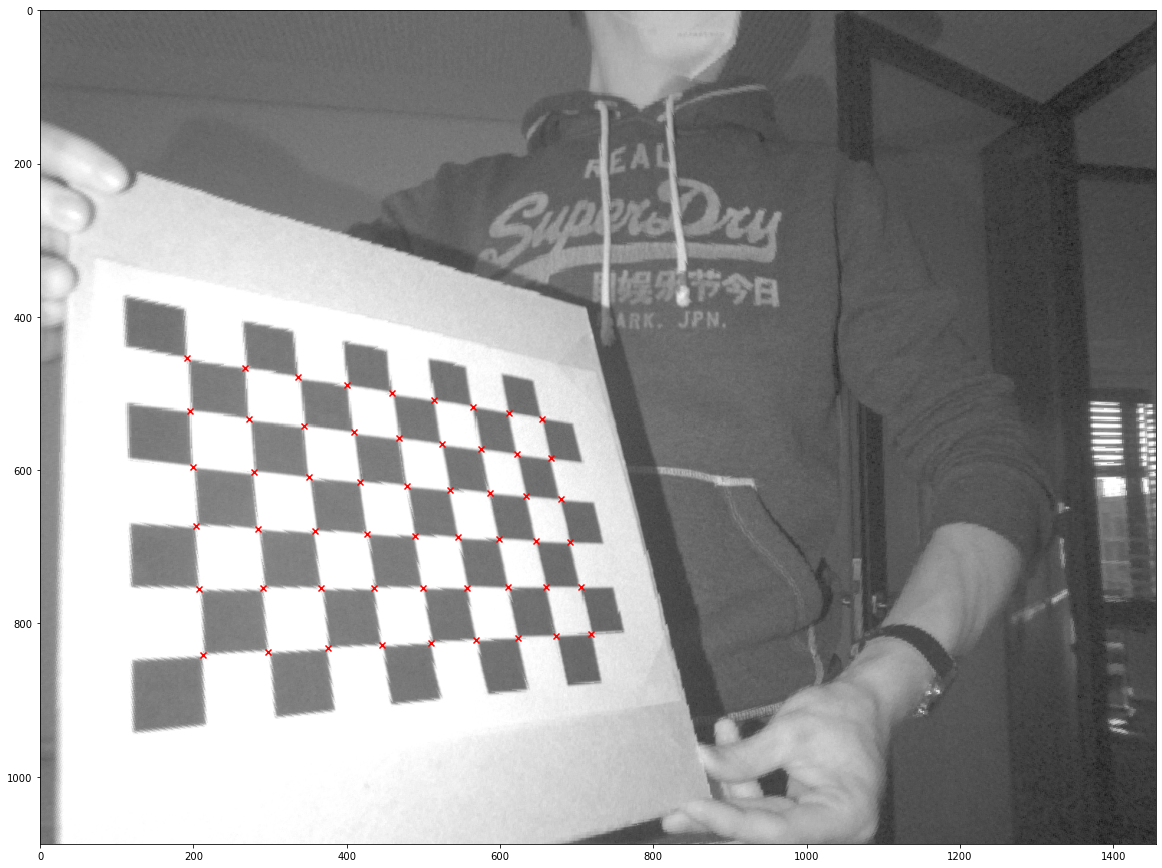

In [17]:
chessboard_corners_proj = reproject(chessboard_positions, transformations_opt[example_image_id,:,:], camera_mat_opt)
plt.figure(figsize=(20,20))
plt.imshow(undistorted_img, cmap='gray')
plt.scatter(chessboard_corners_proj[:,0], chessboard_corners_proj[:,1], marker='x', c='r')
plt.show()

## Conclusion
We have now successfully implemented a basic monocular camera calibration and image-undistortion. The resulting undistorted images (in combination with the esimated camera intrinsics matrix) allow us to work with the perspective projection equation. This is the starting point for more advanced algorithms such as *Structure from Motion* or *Triangulation*  that extract geometric information about the environment from simple camera images.